# 데이터 준비

- 참고자료
  - [[Visualising Korea] 코로나19와의 전쟁에서 생명 구하기 - '사망'에 대한 insights 도출](https://dacon.io/competitions/official/235590/codeshare/949)



데이터 목록
1. Case.csv: 
   - case_id, province, city, group, infection_case, confirmed, latitude, longitude
1. PatientInfo.csv
   - patient_id, global_num, date, province, city, latitude, longitude
1. PatientRoute.csv
   - patient_id, global_num, date,province, city, latitude, longitude
1. Time.csv
   - date, time, test, negative, confirmed, released, deceased
1. TimeAge.csv
   - date, time, age, confirmed, deceased
1. TimeGender.csv
   - date, time, sex, confirmed, deceased
1. TimeProvince.csv
   - date, time, province, confirmed, released, deceased
1. Region.csv
   - code, province, city, latitude, longitude, elementary_school_count, kindergarten_count, university_count, academy_ratio, elderly_population_ratio, elderly_alone_ratio, nursing_home_count
1. Weather.csv
   - code, province, date, avg_temp, min_temp, max_temp, precipitation, max_wind_speed, most_wind_direction, avg_relative_humidity
1. Searchtrend.csv
   - date, cold, flu, pneumonia, coronavirus
1. SeoulFloating.csv
   - date, hour, birth_year, sex, province, city, fp_num
1. Policy.csv
   - policy_id, country, type, gov_policy, detail, start_date, end_date

In [1]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings  
warnings.filterwarnings('ignore')

import os

In [2]:
os.listdir('./data')

['Case.csv',
 'coronavirusdataset_20200430.zip',
 'PatientInfo.csv',
 'PatientRoute.csv',
 'Policy.csv',
 'Region.csv',
 'SearchTrend.csv',
 'SeoulFloating.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv',
 'Weather.csv']

- 참고자료: [변수 이름을 loop 돌려서 할당하기](https://blog.naver.com/nomadgee/220857820094)

In [3]:
tables = []
for name in os.listdir('./data'):
    if name.endswith('csv'):
        table = name.split('.')[0]
        globals()[table] = pd.read_csv(os.path.join('./data', name))
        tables.append(table)
print(tables)

['Case', 'PatientInfo', 'PatientRoute', 'Policy', 'Region', 'SearchTrend', 'SeoulFloating', 'Time', 'TimeAge', 'TimeGender', 'TimeProvince', 'Weather']


In [4]:
# table = 'Case'
# exec("print(%s.head(3))"%(table))
for table in tables:
    print(f'##################{table}##########')
    print(globals()[table].head(3))

##################Case##########
   case_id province           city  group         infection_case  confirmed  \
0  1000001    Seoul        Guro-gu   True    Guro-gu Call Center         98   
1  1000002    Seoul  Dongdaemun-gu   True          Dongan Church         20   
2  1000003    Seoul        Guro-gu   True  Manmin Central Church         41   

    latitude   longitude  
0  37.508163  126.884387  
1  37.592888  127.056766  
2  37.481059  126.894343  
##################PatientInfo##########
   patient_id  global_num   sex  birth_year  age country province  \
0  1000000001        2.00  male     1964.00  50s   Korea    Seoul   
1  1000000002        5.00  male     1987.00  30s   Korea    Seoul   
2  1000000003        6.00  male     1964.00  50s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow             1.00           nan   
1  Jungnang-gu     NaN       overseas inflow             1.00      

# EDA

## 1.1. 감염 경로 유형

In [5]:
data = PatientInfo.copy()

In [6]:
print('the number of unique values in infection_case:',len(data['infection_case'].unique())) 
data['infection_case'].value_counts()

the number of unique values in infection_case: 24


contact with patient                     968
overseas inflow                          604
etc                                      572
Guro-gu Call Center                      112
Shincheonji Church                       107
Onchun Church                             33
Bonghwa Pureun Nursing Home               31
gym facility in Cheonan                   30
Ministry of Oceans and Fisheries          28
Cheongdo Daenam Hospital                  21
Dongan Church                             17
Eunpyeong St. Mary's Hospital             16
Gyeongsan Seorin Nursing Home             15
Seongdong-gu APT                          13
Gyeongsan Jeil Silver Town                12
Milal Shelter                             11
Gyeongsan Cham Joeun Community Center     10
Geochang Church                            6
Changnyeong Coin Karaoke                   4
gym facility in Sejong                     4
Suyeong-gu Kindergarten                    3
Pilgrimage to Israel                       2
River of G

- 100명 정도로는 하나의 그룹이라 부르기 어렵다. 그렇다면 다 합쳐서 집단 감염이라고 해보자.
- 그런데 6명도 집단 감염이라고 할 수 있나 ? 없애버리자.

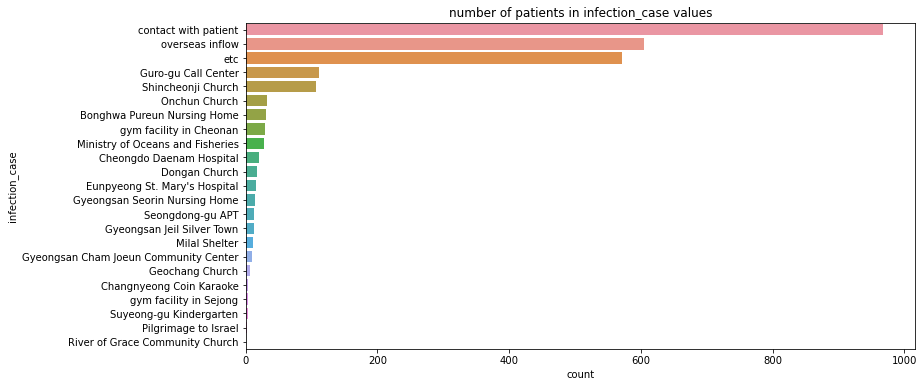

In [7]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,6))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
plt.show()

In [8]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

infection_case_less_than_10 = g[g['patient_id'] < 10].index.tolist()
g[g.index.isin(infection_case_less_than_10)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Geochang Church,6
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


In [9]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_than_10))]
print('data shape after slicing: ', data.shape)

original data shape: (3388, 18)
data shape after slicing:  (3368, 18)


- 결측값 처리

In [10]:
ratio = data['infection_case'].isnull().sum() / len(data['infection_case'])
print(f'{ratio*100:.2f}%를 차지함')

22.80%를 차지함


In [11]:
def categorise(x):
    '''
    categorises infection types
    '''
    if x == 'overseas inflow':
        y = 'overseas'
    elif x == 'contact with patient': 
        y = 'individual'
    elif (x == 'etc') | (pd.isnull(x)):
        y = 'unknown'
    else: 
        y = 'group'
    return y 

data['infection'] = data['infection_case'].apply(lambda x: categorise(x))
print(data.shape)
data.head()

(3368, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


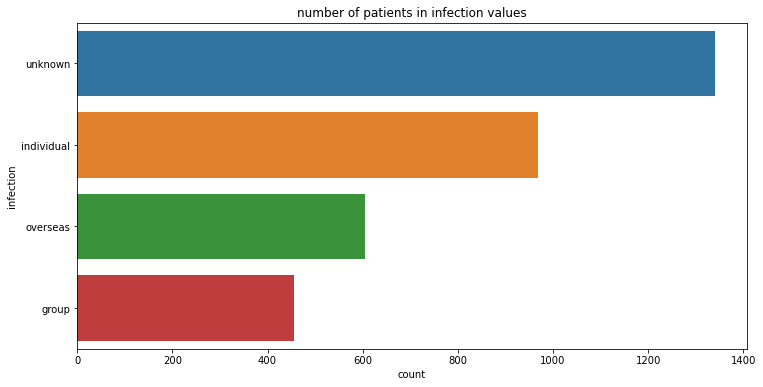

In [12]:
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)

plt.figure(figsize = (12,6))
sns.barplot(y = 'infection', x= 'count', data = g)
plt.title('number of patients in infection values')
plt.show()

## 1.2. 유동성

In [13]:
tables

['Case',
 'PatientInfo',
 'PatientRoute',
 'Policy',
 'Region',
 'SearchTrend',
 'SeoulFloating',
 'Time',
 'TimeAge',
 'TimeGender',
 'TimeProvince',
 'Weather']

In [14]:
data_route = PatientRoute.copy()

In [15]:
print('the number of unique values in type:', len(data_route['type'].unique()))
data_route['type'].value_counts()

the number of unique values in type: 24


etc                            2049
hospital                       1927
store                           641
restaurant                      528
public_transportation           462
airport                         237
pharmacy                        230
church                          148
cafe                            102
pc_cafe                          80
school                           58
lodging                          45
bank                             32
bakery                           26
gym                              20
beauty_salon                     19
real_estate_agency               19
post_office                      17
university                       14
administrative_area_level_1      14
bar                              13
gas_station                      12
academy                          11
karaoke                          10
Name: type, dtype: int64

In [16]:
data_route['type'].isnull().sum()

0

- 재그룹화: 필수적 이동이었는가 ? 부수적 이동이었는가 ?

In [17]:
## categories
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [18]:
essential = essential_edu + essential_admin + necessity + medical 
def type_group_essen(x): 
    group = None
    if x in essential: 
        group = 'essential'
    else:
        group = 'non-essential' 
    return group 

In [19]:
data_route['route_group_essential'] = data_route['type'].apply(lambda x: type_group_essen(x)) 
data_route = data_route[['patient_id', 'type', 'route_group_essential']]
data_route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


- 참고자료: [R friend 데이터 재구조화](https://rfriend.tistory.com/276)

In [20]:
# g = pd.DataFrame(data_route.groupby(['patient_id', 'route_group_essential'])['patient_id'].count())
# g = g.unstack()

g = pd.DataFrame(data_route.groupby(['patient_id', 'route_group_essential'])['patient_id'].count().unstack())
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


- 여기서 nan은 이동하지 않았다는 뜻!

In [21]:
g.fillna(0, inplace = True)
g.reset_index(inplace = True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


In [22]:
# data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data = pd.merge(data, g, on = 'patient_id', how = 'left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,...,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,...,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [23]:
print(data.shape)
data[(data['essential'].isnull()) | (data['non-essential'].isnull())].shape

(3368, 21)


(2169, 21)

- data에 포함된 id 중에는 data_route에서 측정되지 않은 데이터가 2000명이나 있었어
- 일단 포함된 1000명만 생각해보자

In [24]:
print('original data shape:', data.shape)
data_with_route = data[(data['essential'].notnull()) & (data['non-essential'].notnull())] 
print('data shape after removing missing values in essentail/non-essential:', data_with_route.shape)

original data shape: (3368, 21)
data shape after removing missing values in essentail/non-essential: (1199, 21)


## 1.3. 접촉정도

In [25]:
data_with_route['contact_number'].describe()

count    332.00
mean      24.27
std       95.07
min        0.00
25%        2.00
50%        5.00
75%       17.25
max     1160.00
Name: contact_number, dtype: float64

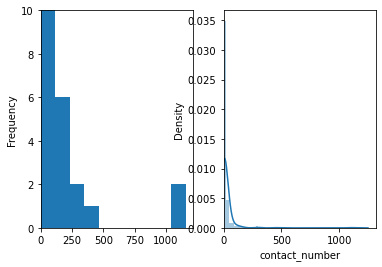

In [26]:
plt.subplot(1,2,1)
data_with_route['contact_number'].plot(kind = 'hist')
plt.ylim(0,10)
plt.xlim(left=0)
plt.subplot(1,2,2)
sns.distplot(data_with_route['contact_number'])
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

In [27]:
data[data['contact_number'] == 1160]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,...,nan,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


In [28]:
print('original data shape:', data.shape)
data = data[data['contact_number'].notnull()]
print('data shape after removing missing values in contact_number:', data.shape)

original data shape: (3368, 21)
data shape after removing missing values in contact_number: (635, 21)


## 1.4. 확진받기까지 걸린 시간 (Diagnosis time)

- Diagnosis time = confirmed_date - symptom_onset_date
- 행동 특성

In [29]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isnull()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isnull()].shape)

data shape: (635, 21)
missing values in symptom_onset_date: (423, 21)
missing values in confirmed_date: (0, 21)


- 다 없앨수도 없고, 증상이 나타난 시점을 모른다는 것은 증상 직후 확진 받았거나 기록이 없거나 하는 경우일 것이다.
- 제거한다.

In [30]:
data

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,...,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,...,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,7000000009,9651.00,female,nan,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,nan,14.00,NaN,2020-03-29,NaN,NaN,isolated,overseas,nan,nan
3364,7000000010,nan,female,nan,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,nan,18.00,NaN,2020-04-03,NaN,NaN,isolated,overseas,nan,nan
3365,7000000011,nan,male,nan,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,...,7000000009.00,5.00,NaN,2020-04-03,NaN,NaN,isolated,individual,nan,nan
3366,7000000012,nan,female,nan,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,...,nan,9.00,NaN,2020-04-03,NaN,NaN,isolated,overseas,nan,nan


In [31]:
np.where((data['symptom_onset_date'] == ' '), None, data['symptom_onset_date'])

array(['2020-01-22', nan, nan, '2020-01-26', nan, nan, nan, nan, nan, nan,
       nan, nan, nan, '2020-02-06', '2020-02-11', '2020-03-19', nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '2020-03-27',
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       '2020-02-21', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, '2020-02-22', nan, nan, '2020-02-20', nan,
       '2020-02-19', nan, '2020-02-22', '2020-02-23', nan, nan,
       '2020-02-22', nan, '2020-02-22', nan, nan, nan, '2020-02-22', nan,
       nan, nan, nan, '2020-02-19', '2020-02-16', '2020-02-23',
       '2020-02-24', '2020-02-21', nan, nan, nan, nan, nan, '2020-02-23',
       '2020-02-19', nan, '2020-02-21', '2020-02-19', '2020-02-23', nan,
       '2020-02-23', nan, '2020-02-22', '2020-02-21', nan, '2020-02-26',
       '2020-02-26', '2020-02-27', '2020-02-21', nan, nan, '2020-02-21',
       nan, '2020-02-28', '2020-02-24', nan, '2020-02-27', '2020-02-23',
       nan, '2

In [32]:
### Cleaning symptom onset date
# data['symptom_onset_date'] == ' '
# data['symptom_onset_date'] = np.where((data['symptom_onset_date'] == ' '), None, data['symptom_onset_date'])

### Remove missing values in symptom_onset_date
print('original data shape: ', data.shape)
data = data[data['symptom_onset_date'].notnull()]
print('data excluding missing values in symptom_onset_date: ', data.shape)

original data shape:  (635, 21)
data excluding missing values in symptom_onset_date:  (212, 21)


In [35]:
### Define time that lapsed between the onset of COVID-19 symptoms and the official COVID-19 diagnosis

## Convert str into date func.
def convert_date(x):
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

In [ ]:
pd.to_datetime(data['symptom_onset_date'], format='%Y-%m-%d').dt.date

In [ ]:
data['symptom_onset_date'].map(lambda x : convert_date(x))

In [40]:
## convert symptom_onset_date/confirmed_date into date format
# data['symptom_onset_date'] = data['symptom_onset_date'].map(lambda x : convert_date(x))
# data['confirmed_date'] = data['confirmed_date'].map(lambda x: convert_date(x))

data['symptom_onset_date'] = pd.to_datetime(data['symptom_onset_date'], format='%Y-%m-%d').dt.date
data['confirmed_date'] = pd.to_datetime(data['confirmed_date'], format='%Y-%m-%d').dt.date

data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00


In [43]:
type(data['symptom_onset_date'][0])

datetime.date

In [46]:
type((data['confirmed_date'] - data['symptom_onset_date'])[0])

pandas._libs.tslibs.timedeltas.Timedelta

In [51]:
## find time lapsed between symptom_onset_date and confirmed_date
data['days_notice'] = data['confirmed_date'] - data['symptom_onset_date'] 
data['hours_notice'] = data['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
data['days'] = data['hours_notice'].apply(lambda x: int(x/24))
data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential,days_notice,hours_notice,days
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,...,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00,1 days,24.00,1
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,...,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00,4 days,96.00,4
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,...,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00,10 days,240.00,10


212 patient_id            212
global_num             64
sex                     2
birth_year             66
age                     9
country                 3
province                8
city                   35
disease                 0
infection_case          9
infection_order         4
infected_by            52
contact_number         43
symptom_onset_date     59
confirmed_date         58
released_date          42
deceased_date           0
state                   3
infection               4
essential              13
non-essential          16
days_notice            23
hours_notice           23
days                   23
dtype: int64


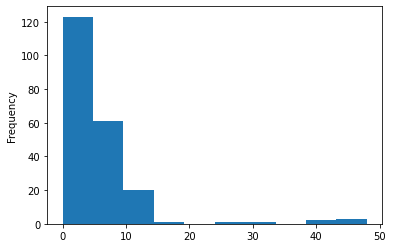

In [58]:
data = data.reset_index(drop=True)
print(len(data), data.nunique())
data['days'].plot(kind='hist')
plt.show()

## [소결론1] 
이상으로 모델에 활용할 네 가지의 행동 특성 1) 감염 경로 유형, 2) 유동성, 3) 접촉 정도, 4) 확진받기까지 걸린 시간의 제작을 모두 완료하였습니다.

# [TIPS]
- 시각화
  - 범주형 → 비율(barplot, pieplot)
  - 연속형 → 분포(histogram, distplot, boxplot)
  - 연속형 x 연속형 → 산점도(plot, scatter)
  - 나머지 케이스 ? 없음